In [1]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import math
from IPython.display import HTML
from matplotlib import rc
from matplotlib.colors import ListedColormap
from colorama import Fore, Back, Style


Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


This code runs with mesa version 3.00 or higher

In [2]:
# check mesa version
print("Mesa version: ", mesa.__version__)

Mesa version:  3.0.2


In [3]:
# Load the Excel file
file_path = 'Floorplan.xlsx'  # Replace with your file path
df = pd.read_excel(file_path, header=None)  # Load the data without assuming any headers

In [4]:
# Initialize lists for each category
self_obstacles = []
self_exits = []
self_signs = []

# Iterate through the DataFrame to find the coordinates for each category
for y in range(df.shape[0]):  # Iterate over rows (height)
    for x in range(df.shape[1]):  # Iterate over columns (width)
        value = df.iloc[y, x]  # Get the value at position (x, y)
        
        # Check the value and store the coordinates in the appropriate list
        if value == 1:
            self_obstacles.append((x, y))
        elif value == 3:
            self_exits.append((x, y))
        elif value == 4:
            self_signs.append((x, y))

# Example print statements to check the lists
print("Obstacles:", self_obstacles)
print("Exits:", self_exits)
print("Signs:", self_signs)

Obstacles: [(0, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (0, 1), (4, 1), (15, 1), (19, 1), (23, 1), (0, 2), (14, 2), (15, 2), (19, 2), (23, 2), (0, 3), (4, 3), (14, 3), (15, 3), (19, 3), (23, 3), (24, 3), (27, 3), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (0, 4), (4, 4), (5, 4), (15, 4), (23, 4), (33, 4), (0, 5), (4, 5), (5, 5), (15, 5), (16, 5), (17, 5), (21, 5), (22, 5), (33, 5), (0, 6), (4, 6), (5, 6), (15, 6), (33, 6), (0, 7), (4, 7), (5, 7), (15, 7), (28, 7), (33, 7), (0, 8), (4, 8), (5, 8), (15, 8), (27, 8), (28, 8), (29, 8), (33, 8), (0, 9), (4, 9), (5, 9), (26, 9), (27, 9), (28, 9), (29, 9), (30, 9), (33, 9), (0, 10), (4, 10), (5, 10), (26, 10), (27, 10), (28, 10), (29, 10), (30, 10), (33, 10), (0, 11), (4, 11), (5, 11), (15, 11), (27, 11), (28, 11), 

In [5]:
# Function to calculate Euclidean distance (distance between two points)
def euclidean_distance(pos1, pos2):
    # Use the formula to calculate distance between two coordinates
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

# Base Model

In [6]:
###################
### AGENT CLASS ###
###################

# Define the NavigationAgent class
class NavigationAgent(Agent):
    def __init__(self, model, vision=8):  # Default vision range of 8 cells
        super().__init__(model)  # MESA `Agent` class initialization
        self.found_exit = False  # Track if agent has reached the exit
        self.previous_pos = None  # Previous position of the agent
        self.vision = vision  # Vision range of the agent

    # Function to move the agent towards a target (exit or sign)
    def move_towards_target(self, target_locations):
        self.previous_pos = self.pos  # Store the current position before moving
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        
        min_distance = float('inf')  # Start with a very large distance
        best_step = None  # Initialize best step as None
        
        # Check each possible step to find the one closest to the target
        for step in possible_steps:
            # Only consider steps that don't have obstacles and have fewer than 8 agents
            if step not in self.model.obstacles and len(self.model.grid.get_cell_list_contents(step)) < 8:
                dist_to_closest_target = min(euclidean_distance(step, target_loc) for target_loc in target_locations)
                if dist_to_closest_target < min_distance:
                    min_distance = dist_to_closest_target
                    best_step = step  # Update best step to be closer to the target
                    #print(f" current pos = {self.pos} and best step = {best_step}" )
        
        if best_step:
            # MESA `move_agent` function moves the agent to the new cell
            #print(f" current pos = {self.pos} and best step = {best_step}" )
            self.model.grid.move_agent(self, best_step)
            

    # Function to move the agent randomly if no target is in sight
    def move_randomly(self):
        self.previous_pos = self.pos
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        
        # Filter steps to only those without obstacles and with fewer than 8 agents
        valid_steps = [step for step in possible_steps if step not in self.model.obstacles and len(self.model.grid.get_cell_list_contents(step)) < 8]
        
        if valid_steps:
            # Randomly choose a valid position and move there
            random_step = self.random.choice(valid_steps)
            # MESA `move_agent` function moves the agent to the chosen position
            self.model.grid.move_agent(self, random_step)

    # Define the actions the agent will take in each step
    def step(self):
        # If the agent is at the exit, mark as exited
        if self.pos in self.model.exit_locations:
            self.found_exit = True  # Set the agent's exit status to True
            self.model.grid.remove_agent(self)  # MESA function to remove the agent from the grid
            self.remove()  # Remove from AgentSet
            self.model.cumulative_exited += 1  # Count this agent in cumulative exited agents
        else:
            # MESA `get_neighborhood` checks the agent's vision area
            vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
            
            # Check for exits and signs in the vision area
            exits_in_vision = [exit_loc for exit_loc in self.model.exit_locations if exit_loc in vision_area]
            signs_in_vision = [sign_loc for sign_loc in self.model.signs if sign_loc in vision_area]
            
            # Prioritize movement based on the order of priorities
            if exits_in_vision:
                self.move_towards_target(exits_in_vision)  # Move towards the nearest exit
                #print(f" Agent {self.unique_id} moving towards exits at {exits_in_vision}.")
            elif signs_in_vision:
                self.move_towards_target(signs_in_vision)  # Move towards the nearest sign
                #print(f" Agent {self.unique_id} moving towards sign at {signs_in_vision}.")
            else:
                self.move_randomly()  # Move randomly if no exits or signs are visible

###################
### MODEL CLASS ###
###################

# Define the model class to handle the overall environment
class FloorPlanModel(Model):
    def __init__(self, width, height, num_agents, agent_vision):
        super().__init__()  # `Model` class initialization
        
        # Basic model settings
        self.num_agents = num_agents
        self.agent_vision = agent_vision
        self.grid = MultiGrid(width, height, False)  # MESA grid with dimensions; False means no wrapping
        self.exit_locations = self_exits # Place exits

        # Define obstacles and signs in the grid
        self.obstacles = self_obstacles
        self.signs = self_signs 
        
        # Initialize cumulative exited count
        self.cumulative_exited = 0

        # Initialize DataCollector (MESA tool for tracking metrics across steps)
        self.datacollector = DataCollector(
            model_reporters={
                "Active Agents": lambda m: len(m.agents),  # Count of agents still active
                "Exited Agents": lambda m: sum(1 for agent in m.agents if isinstance(agent, NavigationAgent) and agent.found_exit),
                "Cumulative Exited Agents": lambda m: m.cumulative_exited,  # Cumulative exited count
                "Agents per Cell": self.count_agents_per_cell  # Counts agents in each cell
            },
            agent_reporters={
                "Found Exit": lambda a: a.found_exit if isinstance(a, NavigationAgent) else None  # Reports exit status per agent
            }
        )

        self.place_agents(agent_vision)  # Place agents on the grid
        self.datacollector.collect(self) # Collect data at the start of the simulation
        

    # Function to randomly place agents in the grid
    def place_agents(self, agent_vision):
        for i in range(self.num_agents):
            agent = NavigationAgent(self, vision = agent_vision)  # Create agent with initial vision range of 5 cells
            placed = False  # Track if the agent is successfully placed
            while not placed:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                cell_contents = self.grid.get_cell_list_contents((x, y))

                # Only place agent if cell has no obstacles and fewer than 8 agents
                if (x, y) not in self.obstacles and len(cell_contents) < 8:
                    self.grid.place_agent(agent, (x, y))  # MESA function to place agent in grid
                    placed = True  # Mark as placed
                    # if you want to see the initial placement of the agents, uncomment the line below. This will print the initial position of the agents
                    # print(f"Agent {i} placed at: ({x}, {y})")

    # Function to count agents in each cell
    def count_agents_per_cell(self):
        agent_counts = {}  # Dictionary to store agent counts by cell position
        # MESA `coord_iter` function iterates over grid cells and their contents
        for cell in self.grid.coord_iter():
            cell_contents, (x, y) = cell  # Unpack cell contents and coordinates
            # Count NavigationAgents in each cell
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            if nav_agent_count > 0:
                agent_counts[(x, y)] = nav_agent_count
        return agent_counts
    
    # Function to get the grid data for visualization
    def get_grid(self):
        # 0: empty, 1: obstacle, 2: agent, 3: exit, 4: sign
        grid_data = np.zeros((self.grid.height, self.grid.width)) # Adjust order to (height, width)
        
        # Mark obstacles on the grid
        for x, y in self.obstacles:
            grid_data[y, x] = 1
        
        # Mark agents on the grid
        for agent in self.agents:
            if isinstance(agent, NavigationAgent):
                x, y = agent.pos
                grid_data[y, x] = 2
        
        # Mark signs and exit
        for x, y in self.signs:
            grid_data[y, x] = 4
        for x, y in self.exit_locations:
            grid_data[y, x] = 3  # Set exit cells to value 3

        return grid_data

    # Model step function to update the simulation
    def step(self):
        self.agents.do("step")  # MESA 3.0 function to execute the `step` function of each agent
        self.datacollector.collect(self)  # MESA DataCollector collects metrics at each step




In [7]:
#grid_data = model.get_grid()

In [8]:
# Run the model and see the results
model = FloorPlanModel(34, 20, 1, 9) # run the model with 34x20 grid and 100 agents and a vision of 9
for i in range(100): # run the model for 100 steps
    model.step() # step the model by 1

# Collect the data from the model
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

grid_data = model.get_grid()



In [9]:
# def print_floorplan(model):
#     """
#     Prints the floor plan of the model with visual representation of obstacles, signs, exits, and agents.

#     :param model: The FloorPlanModel instance to visualize.
#     """
#     grid_data = model.get_grid()

#     # Define symbols for the different entities
#     symbols = {
#         0: "  ",  # Empty space
#         1: Back.BLACK + "  " + Style.RESET_ALL,  # Obstacle (black background)
#         2: Back.GREEN + "  " + Style.RESET_ALL,  # Agent (green background)
#         3: Back.RED + "  " + Style.RESET_ALL,  # Exit (red background)
#         4: Back.YELLOW + "  " + Style.RESET_ALL,  # Sign (yellow background)
#     }

#     print("\nFloor Plan:")
#     for y in range(grid_data.shape[0]):  # Loop through each row
#         for x in range(grid_data.shape[1]):  # Loop through each column
#             cell_value = grid_data[y, x]
#             print(symbols[cell_value], end="")
#         print()  # Newline after each row

# print_floorplan(model)

In [10]:
model_data # print the model data

,Active Agents,Exited Agents,Cumulative Exited Agents,Agents per Cell
0,1,0,0,"{(26, 15): 1}"
1,1,0,0,"{(27, 15): 1}"
2,1,0,0,"{(28, 15): 1}"
3,1,0,0,"{(29, 15): 1}"
4,1,0,0,"{(30, 15): 1}"
...,...,...,...,...
96,1,0,0,"{(32, 15): 1}"
97,1,0,0,"{(31, 15): 1}"
98,1,0,0,"{(32, 15): 1}"
99,1,0,0,"{(31, 15): 1}"


In [11]:
agent_data # print the agent data

,,Found Exit
Step,AgentID,
0,1,False
1,1,False
2,1,False
3,1,False
4,1,False
...,...,...
96,1,False
97,1,False
98,1,False


# Visualization with User Interface
You don't have to understand every single line in the visualisation code below. Please understand the code to extend that you can introduce changes to it when needed

In [12]:
# Visualization Function
def plot_grid(model, ax):
    rc("animation", embed_limit=100)  # Set a higher limit in MB to allow smoother animation playback
    grid_data = model.get_grid()  # Retrieve the current state of the grid from the model
    ax.clear()  # Clear any previous plots on the axes to prevent overlap in visualizations
    
    # Define color mappings:
    # 0 (empty) -> white, 1 (obstacle) -> black, 2 (agent) -> blue,
    # 3 (exit) -> green, 4 (sign) -> orange
    cmap = mcolors.ListedColormap(['white', 'black', 'blue', 'green', 'orange'])
    bounds = [0, 1, 2, 3, 4]  # Boundaries to separate each category
    norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalizes values to assign colors to each category
    
    # Display the grid data with color mapping applied.
    # Setting 'origin' to 'lower' places the (0,0) coordinate at the bottom-left.
    ax.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
    
    # Add grid lines for better cell visibility
    ax.grid(which='both', color='gray', linestyle='-', linewidth=2)
    
    # Customize grid display: set grid to start from -0.5 with labels at intervals of 1
    # Set minor ticks for cell boundaries, with thicker and darker lines
    ax.set_xticks(np.arange(-0.5, model.grid.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.grid.height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1.5)  # Thicker, darker lines for cell boundaries

    # Set major ticks for labels at intervals of 5, with lighter and thinner lines
    ax.set_xticks(np.arange(0, model.grid.width, 5), minor=False)
    ax.set_yticks(np.arange(0, model.grid.height, 5), minor=False)
    ax.grid(which='major', color='lightgray', linestyle='-', linewidth=0)  # invisible line

    
    # Label the exit point on the grid in red text for easy identification
    for exit_x, exit_y in model.exit_locations:
        ax.text(exit_x, exit_y, 'EXIT', ha='center', va='center', fontsize=12, color='red', fontweight='bold')

    #for exit_x, exit_y in self.exit_locations:  #wellicht toevoegen?
    #    grid_data[exit_y, exit_x] = 3

    # Add labels for each sign location in black text for visibility
    for sign_pos in model.signs:
        x, y = sign_pos
        ax.text(x, y, 'SIGN', ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Set the title to show the current step number in the model
    ax.set_title(f"Step {model.steps}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=7)  # Control tick label size
    
    # Draw movement arrows for agents to show the direction they are traveling
    for agent in model.agents:
        # Only draw arrow if the agent has moved and is a NavigationAgent
        if isinstance(agent, NavigationAgent) and agent.previous_pos:
            start_x, start_y = agent.previous_pos  # Previous position of the agent
            end_x, end_y = agent.pos  # Current position of the agent
            
            # Draw an arrow from the previous position to the current position
            ax.arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                head_width=0.3, head_length=0.3, fc='yellow', ec='yellow'  # Yellow arrow for movement direction
            )

# Animation Update Function
def update(frame, model, ax):
    # For every frame, update the model state if it's not the first frame
    if frame > 0:
        model.step()  # Run one step of the model simulation
    plot_grid(model, ax)  # Redraw the grid with updated agent positions
    
# Run the Animation with a larger figure size
def run_animation(model, steps):
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a 10x10 figure for the plot
    plot_grid(model, ax)  # Plot the initial grid state
    # Create an animation that updates the grid for each step
    anim = FuncAnimation(fig, update, frames=steps+1, fargs=(model, ax), repeat=False)
    plt.close(fig)  # Close the figure after animation creation to avoid duplicate displays
    return anim

# Your imports and function definitions remain the same, up until where you initialize and run the model
import ipywidgets as widgets  # For interactive widgets (slider, button)
from IPython.display import display, HTML  # To display widgets and HTML animations
import time  # For tracking elapsed time

# Slider to choose the number of agents
agent_slider = widgets.IntSlider(
    value=1,      # Default starting number of agents
    min=1,        # Minimum number of agents allowed
    max=500,       # Maximum number of agents allowed
    step=10,       # Step size for slider increments
    description='Num Agents:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the number of time steps (frames) for the animation
time_step_slider = widgets.IntSlider(
    value=50,      # Default starting number of steps
    min=1,         # Minimum time steps allowed
    max=500,       # Maximum time steps allowed
    step=1,        # Step size for slider increments
    description='Time Steps:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Slider to choose the vision range (vision radius) of agents
vision_slider = widgets.IntSlider(
    value=9,      # Default starting vision range
    min=1,        # Minimum vision range
    max=20,       # Maximum vision range
    step=1,       # Step size for slider increments
    description='Vision:',  # Label for the slider
    continuous_update=False     # Only update value when slider is released
)

# Button to start the simulation with current slider settings
run_button = widgets.Button(description="Run Simulation")

# Output widget for displaying the animation and elapsed time
output_widget = widgets.Output()

# Label to show elapsed time during the simulation
elapsed_time_label = widgets.Label(value="Elapsed time: 0.0 seconds")

# Flag variable to control timing function
stop_timer = False

# Display the interface with sliders, button, label, and output area
display(agent_slider, time_step_slider, vision_slider, run_button, elapsed_time_label, output_widget)

# Define the function to initialize and run the model
def run_model(change):
    global stop_timer, model_data, agent_data  # Allow variables to be accessed globally
    with output_widget:  # Use output widget to display the animation
        output_widget.clear_output()  # Clear any previous output
        num_agents = agent_slider.value  # Get the number of agents from the slider
        time_steps = time_step_slider.value  # Get the number of steps from the slider
        agent_vision = vision_slider.value  # Get the vision range from the slider
        model = FloorPlanModel(width=34, height=20, num_agents=num_agents, agent_vision=agent_vision)  # Initialize the model


        # Reset timer flag and start timing for the animation
        stop_timer = False
        start_time = time.time()

        def update_time_label():
            while not stop_timer:  # Keep updating time label until timer stops
                elapsed_time = time.time() - start_time
                elapsed_time_label.value = f"Elapsed time: {elapsed_time:.1f} seconds"
                time.sleep(0.1)  # Update every 0.1 seconds for real-time effect

        # Start elapsed time tracking in a separate thread
        import threading
        timer_thread = threading.Thread(target=update_time_label, daemon=True)
        timer_thread.start()

        # Run the animation with selected number of steps
        anim = run_animation(model, steps=time_steps)

        # Display the animation output in HTML format
        output = HTML(anim.to_jshtml())
        display(output)

        # Stop the timer after the simulation completes
        stop_timer = True
        elapsed_time = time.time() - start_time
        elapsed_time_label.value = f"Total elapsed time: {elapsed_time:.1f} seconds"

        # Retrieve and display model and agent data after simulation completes
        model_data = model.datacollector.get_model_vars_dataframe()  # Data for the model over time
        agent_data = model.datacollector.get_agent_vars_dataframe()  # Data for each agent over time
    return model, model_data, agent_data  # Return model and data for further inspection

# Attach the run_model function to the run button click event
run_button.on_click(run_model)

IntSlider(value=1, continuous_update=False, description='Num Agents:', max=500, min=1, step=10)

IntSlider(value=50, continuous_update=False, description='Time Steps:', max=500, min=1)

IntSlider(value=9, continuous_update=False, description='Vision:', max=20, min=1)

Button(description='Run Simulation', style=ButtonStyle())

Label(value='Elapsed time: 0.0 seconds')

Output()

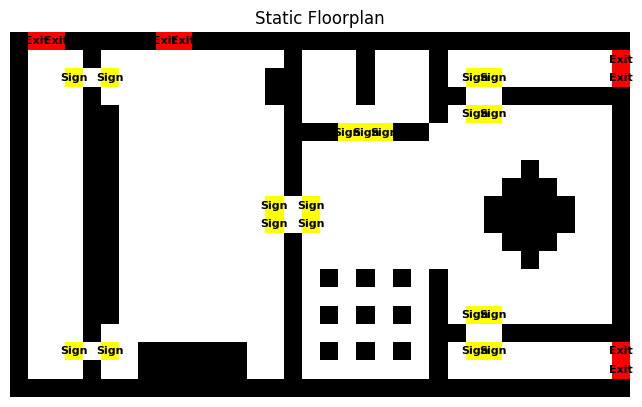

In [13]:
def visualize_static_floorplan(model):
    # Get the grid data from the model (static view, no agents)
    grid_data = model.get_grid()

    # Create a colormap with numerical values for each cell type
    # 0: empty (white), 1: obstacle (black), 2: (agent), 3: exit (red), 4: sign (yellow)
    cmap = ListedColormap(["white", "black", "white", "red", "yellow"])
    norm = plt.Normalize(vmin=0, vmax=4)

    # Visualize the floorplan
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_data, cmap=cmap, norm=norm)

    for y in range(grid_data.shape[0]):
        for x in range(grid_data.shape[1]):
            if grid_data[y, x] == 3:  # Exit
                plt.text(x, y, 'Exit', color='black', ha='center', va='center', fontsize=8, weight='bold')
            elif grid_data[y, x] == 4:  # Sign
                plt.text(x, y, 'Sign', color='black', ha='center', va='center', fontsize=8, weight='bold')

    plt.title("Static Floorplan")
    plt.axis("off")  # Remove axis for a cleaner look
    plt.show()

# Usage: Assuming the model is already created
visualize_static_floorplan(model)

In [14]:
print("\nModel Data:")
model_data


Model Data:


,Active Agents,Exited Agents,Cumulative Exited Agents,Agents per Cell
0,1,0,0,"{(26, 15): 1}"
1,1,0,0,"{(27, 15): 1}"
2,1,0,0,"{(28, 15): 1}"
3,1,0,0,"{(29, 15): 1}"
4,1,0,0,"{(30, 15): 1}"
...,...,...,...,...
96,1,0,0,"{(32, 15): 1}"
97,1,0,0,"{(31, 15): 1}"
98,1,0,0,"{(32, 15): 1}"
99,1,0,0,"{(31, 15): 1}"


In [15]:
print("\nAgent Data:")
agent_data.head(40)



Agent Data:


,,Found Exit
Step,AgentID,
0,1,False
1,1,False
2,1,False
3,1,False
4,1,False
5,1,False
6,1,False
7,1,False
8,1,False


In [16]:
# Uncomment the code below to display the 'Agents per Cell' data for each step

print("Agents per Cell at each step:")
for step, agents_per_cell in model_data["Agents per Cell"].items():
   print(f"\nStep {step}:")
   for cell, count in agents_per_cell.items():
       print(f"  Cell {cell}: {count} agent(s)")

Agents per Cell at each step:

Step 0:
  Cell (26, 15): 1 agent(s)

Step 1:
  Cell (27, 15): 1 agent(s)

Step 2:
  Cell (28, 15): 1 agent(s)

Step 3:
  Cell (29, 15): 1 agent(s)

Step 4:
  Cell (30, 15): 1 agent(s)

Step 5:
  Cell (31, 15): 1 agent(s)

Step 6:
  Cell (32, 15): 1 agent(s)

Step 7:
  Cell (31, 15): 1 agent(s)

Step 8:
  Cell (32, 15): 1 agent(s)

Step 9:
  Cell (31, 15): 1 agent(s)

Step 10:
  Cell (32, 15): 1 agent(s)

Step 11:
  Cell (31, 15): 1 agent(s)

Step 12:
  Cell (32, 15): 1 agent(s)

Step 13:
  Cell (31, 15): 1 agent(s)

Step 14:
  Cell (32, 15): 1 agent(s)

Step 15:
  Cell (31, 15): 1 agent(s)

Step 16:
  Cell (32, 15): 1 agent(s)

Step 17:
  Cell (31, 15): 1 agent(s)

Step 18:
  Cell (32, 15): 1 agent(s)

Step 19:
  Cell (31, 15): 1 agent(s)

Step 20:
  Cell (32, 15): 1 agent(s)

Step 21:
  Cell (31, 15): 1 agent(s)

Step 22:
  Cell (32, 15): 1 agent(s)

Step 23:
  Cell (31, 15): 1 agent(s)

Step 24:
  Cell (32, 15): 1 agent(s)

Step 25:
  Cell (31, 15): 1 a